<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Predicting shots made per game by Kobe Bryant

_Authors: Kiefer Katovich (SF)_

---

In this lab you'll be using regularized regression penalties Ridge, Lasso, and Elastic Net to try and predict how many shots Kobe Bryant made per game in his career.

The Kobe shots dataset has hundreds of columns representing different characteristics of each basketball game. Fitting an ordinary linear regression using every predictor would dramatically overfit the model considering the limited number of observations (games) we have available. Furthermore, many of the predictors have significant multicollinearity. 

**Warning:** Some of these calculations are computationally expensive and may take a while to execute.  It may be worth while to only use a portion of the data to perform these calculations, especially if you have experienced kernel issues in the past.

---

### 1. Load packages and data

In [3]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
kobe = pd.read_csv('../data/kobe_superwide_games.csv')
kobe.head(20)

,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
3,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
4,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
5,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,6
6,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,7
7,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,8
8,4.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,9
9,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,10


---

### 2. Examine the data

- How many columns are there? 645 columns, 1558 rows
- Examine what the observations (rows) and columns represent.
- Why is this data that regularization might be particularly useful for?

In [10]:
# All values in row 300 that are not equal to zero
kobe.loc[300, (kobe != 0).all()]

MONTH                   5.0
SECONDS_REMAINING     418.0
PERIOD                 35.0
SEASON_GAME_NUMBER     80.0
CAREER_GAME_NUMBER    302.0
Name: 300, dtype: float64

In [17]:
# All features in row 300 with value 1.0
row = kobe.iloc[300]
one_values = row.index[row == 1.0]
print(one_values)

Index(['AWAY_GAME', 'SEASON_OPPONENT:por:1999-00', 'SEASON:1999-00',
       'PLAYOFFS', 'SHOT_ZONE_BASIC:in_the_paint_(non-ra)',
       'SHOT_ZONE_BASIC:restricted_area', 'COMBINED_SHOT_TYPE:dunk'],
      dtype='object')


In [3]:
kobe.shape

(1558, 645)

In [11]:
kobe.columns[600:645]

Index(['ACTION_TYPE:driving_slam_dunk_shot', 'ACTION_TYPE:dunk_shot',
       'ACTION_TYPE:fadeaway_bank_shot', 'ACTION_TYPE:fadeaway_jump_shot',
       'ACTION_TYPE:finger_roll_layup_shot', 'ACTION_TYPE:finger_roll_shot',
       'ACTION_TYPE:floating_jump_shot', 'ACTION_TYPE:follow_up_dunk_shot',
       'ACTION_TYPE:hook_bank_shot', 'ACTION_TYPE:hook_shot',
       'ACTION_TYPE:jump_bank_shot', 'ACTION_TYPE:jump_hook_shot',
       'ACTION_TYPE:jump_shot', 'ACTION_TYPE:layup_shot',
       'ACTION_TYPE:pullup_bank_shot', 'ACTION_TYPE:pullup_jump_shot',
       'ACTION_TYPE:putback_dunk_shot', 'ACTION_TYPE:putback_layup_shot',
       'ACTION_TYPE:putback_slam_dunk_shot', 'ACTION_TYPE:reverse_dunk_shot',
       'ACTION_TYPE:reverse_layup_shot', 'ACTION_TYPE:reverse_slam_dunk_shot',
       'ACTION_TYPE:running_bank_shot', 'ACTION_TYPE:running_dunk_shot',
       'ACTION_TYPE:running_finger_roll_layup_shot',
       'ACTION_TYPE:running_finger_roll_shot', 'ACTION_TYPE:running_hook_shot',
       

In [10]:
# Each row is a game (1558)
# Columns show the season when game took place against which team. 
# There are also columns specifying what kind of shot exactly was made.
# Column 'SHOTS_MADE' is our target variable for prediction
# Dataset is good for regularization because there are so many columns (feature selection),
# Many of the columns represent similar things (multicollinearity), e.g. seasons

---

### 3. Make predictor and target variables. Standardize the predictors.

Why is normalization necessary for regularized regressions?  Normalizing the data is necessary for regularized regressions because different inputs are often measured on different scales which will wrongly influence the coefficient of our features, i.e. we ensure that all inputs are measured on a similar scale so that their coefficients are weighed on a similar scale as well

Use the `sklearn.preprocessing` class `StandardScaler` to standardize the predictors.

In [11]:
# Standardization is necessary for regularized regression because beta values for each predictor must be on the same scale. 
# Some predictors are 0/1 answers, some are counts, some are times and dates etc.
# If betas are different sizes just because of the scale of predictor variables,
# the regularization term cannot determine which betas are more/less important

In [18]:
kobe.iloc[:, 1:]

,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,SEASON_OPPONENT:atl:2005-06,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1,1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,2,2
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,3,3
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,4,4
4,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.105263,0.0,0.000000,0.052632,62,1555
1554,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,63,1556
1555,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.045455,0.0,0.045455,0.045455,64,1557
1556,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.000000,65,1558


In [19]:
# Target variable
y = kobe['SHOTS_MADE'].values

# Features variable is all columns starting from 'AWAY_GAME'
X = kobe.iloc[:, 1:]

In [20]:
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# use the "fit_transform" function to standardize the X design matrix
X_ss = ss.fit_transform(X)

---

### 4. Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

Cross-validate the $R^2$ of an ordinary linear regression model with 10 cross-validation folds.

How does it perform?

In [22]:
# Simple Linear Regression model
lr_model = LinearRegression()

lr_scores = cross_val_score(lr_model, X_ss, y, cv=10)

print(lr_scores)
print(np.mean(lr_scores))

[-6.85617211e+28 -2.40078926e+28 -1.33077488e+28 -1.77090016e+28
 -2.31480491e+28 -7.50698125e+27 -5.24648568e+27 -1.97572409e+28
 -1.75859183e+28 -4.46515983e+28]
-2.4148263774796837e+28


In [ ]:
# The mean R2 is extremely small (-0.00000...2415) 
# All the R2 scores are negative in cross-validation (model fits worse than horizontal line).
# The linear regression is performing far worse than baseline on the test sets.
# The model is probably dramatically 'overfitting', and redundant variables are affecting coefficients in weird ways.

---

### 5. Find an optimal value for Ridge regression alpha using `RidgeCV`.

[Go to the documentation and read how RidgeCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

> *Hint: once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Ridge performs best searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit!


In [23]:
ridge_alphas = np.logspace(0, 5, 200)

# Do not store individual cv_values (store_cv_values=True) - takes too long!
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_ss, y)

print(optimal_ridge.alpha_)

775.2597488629465


C:\Users\shmel\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
#print(optimal_ridge.best_score_)

In [24]:
print(optimal_ridge.intercept_)

7.358793324775353


In [25]:
print(optimal_ridge.coef_)

[-6.76898152e-02 -1.78567171e-02  5.74249620e-03  1.28568012e-02
 -1.15147551e-02  4.74421316e-02  3.26391649e-06  3.05126903e-02
  3.43480781e-03  1.88529944e-03  3.07772929e-02 -4.02230210e-03
 -3.93777163e-02  5.21469986e-02 -1.05134792e-02 -2.89527690e-02
  3.08334176e-03 -3.94317921e-02  5.71957630e-02 -4.32634170e-02
 -1.04270037e-02 -2.62038262e-02 -1.88369349e-02  9.22376999e-03
  3.11458273e-02 -6.01280610e-02 -8.70512115e-02 -4.06863431e-02
 -1.57422198e-03  5.91745397e-03  4.91974437e-02 -5.51453721e-02
  6.34800108e-03 -1.56986028e-02  3.89959643e-02 -2.05765608e-02
 -3.24934695e-03  8.75102735e-03 -1.01662020e-01 -8.49691213e-04
 -5.47508574e-02  7.82169137e-03 -3.22557030e-02 -3.26905229e-02
 -6.45135643e-03  2.57645571e-02  1.21732275e-02  3.66491851e-03
  1.28349952e-02  3.14736560e-02 -3.95491168e-02 -2.56270423e-02
  3.30230415e-02 -3.02522416e-02  1.41520774e-02  9.04911090e-03
 -9.85312971e-03  1.14265261e-03  2.00901834e-02  2.09226224e-03
 -3.81378488e-02  1.95774

---

### 6. Cross-validate the Ridge regression $R^2$ with the optimal alpha.

Is it better than the Linear regression? If so, why might this be?

In [28]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_ss, y, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.5822626  0.52880462 0.4869004  0.59583817 0.52396335 0.52942952
 0.52842192 0.41153448 0.39857643 0.44489752]
0.5030628996817685


In [ ]:
# Average R2 value of 0.5 for validation means 50% of the data is being represented during modelling which is much better score
# Ridge regression has limited effects of non-important features

---

### 7. Find an optimal value for Lasso regression alpha using `LassoCV`.

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) It is very similar to `RidgeCV`.

> *Hint: again, once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Lasso, unlike Ridge, performs best searching for alpha through linear space (`np.linspace`). However, you can actually let the LassoCV decide itself what alphas to use by instead setting the keyword argument `n_alphas=` to however many alphas you want it to search over. It is recommended to let sklearn choose the range of alphas.

_**Tip:** If you find your CV taking a long time and you're not sure if its working set `verbose =1`._

In [29]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_ss, y)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.06790539979326354


---

### 8. Cross-validate the Lasso $R^2$ with the optimal alpha.

Is it better than the Linear regression? Is it better than Ridge? What do the differences in results imply about the issues with the dataset?

In [30]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_ss, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.61603625 0.52641159 0.53888743 0.61322432 0.54627539 0.5554072
 0.52716822 0.44849563 0.4646267  0.51838952]
0.5354922262084527


In [ ]:
# Lasso performs much better than Linear and slightly better than the Ridge (54%)

# Lasso deals primarily with feature selection of valuable variables, eliminating ones that are not useful. 

# This also takes care of multicollinearity, but in a different way: 
# it chooses the "best" of the correlated variables and zeros-out the other redundant ones.

# This implies there were too many useless variables in data which Lasso simply got rid of entirely.

---

### 9. Look at the coefficients for variables in the Lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original dataset are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots Kobe made in a game?

> **Note:** if you only fit the Lasso within `cross_val_score`, you will have to refit it outside of that
function to pull out the coefficients.

In [31]:
lasso.fit(X_ss, y)

Lasso(alpha=0.06790539979326354, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
579,COMBINED_SHOT_TYPE:jump_shot,1.233880,1.233880
574,SHOT_TYPE:2pt_field_goal,0.866201,0.866201
566,SHOT_ZONE_BASIC:restricted_area,0.453050,0.453050
577,COMBINED_SHOT_TYPE:dunk,0.274926,0.274926
611,ACTION_TYPE:jump_shot,-0.272130,0.272130
575,SHOT_TYPE:3pt_field_goal,0.140492,0.140492
582,SECONDS_REMAINING,0.132360,0.132360
612,ACTION_TYPE:layup_shot,-0.129658,0.129658
423,SEASON_OPPONENT:sac:1999-00,0.127065,0.127065
561,SHOT_ZONE_BASIC:above_the_break_3,0.118469,0.118469


In [34]:
print('Percent variables zeroed out:', 100 * (np.sum((lasso.coef_ == 0))/float(X.shape[0])))

Percent variables zeroed out: 32.60590500641848


In [ ]:
# 32.6% of variables were zeroed out

# The most important predictors are features carrying the greatest coefficients - see top 10 variables in dataframe above

---

### 10. Find an optimal value for Elastic Net regression alpha using `ElasticNetCV`.

[Go to the documentation and read how ElasticNetCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: strength of regularization
- `l1_ratio`: amount of ridge vs. lasso (0 = all ridge, 1 = all lasso)
    
Do not include 0 in the search for `l1_ratio`: it will not allow it and break!

You can use `n_alphas` for the alpha parameters instead of setting your own values: highly recommended!

Also - be careful setting too many l1_ratios over cross-validation folds in your search. It can take a very long time if you choose too many combinations and for the most part there are diminishing returns in this data.

In [37]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10, verbose=1)
optimal_enet.fit(X_ss, y)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

............................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  4.2min finished


0.07271360998818006
0.9587500000000001


In [ ]:
# Optimal alpha is 0.073
# Optimal L1-ratio is 0.96 which is mostly Lasso regression

---

### 11. Cross-validate the ElasticNet $R^2$ with the optimal alpha and l1_ratio.

How does it compare to the Ridge and Lasso regularized regressions?

In [38]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_ss, y, cv=10)

print(enet_scores)
print(np.mean(enet_scores))

[0.61742795 0.52697978 0.53864379 0.61332045 0.54728018 0.55547707
 0.52548033 0.4485161  0.46407359 0.52059974]
0.5357798983416926


In [ ]:
# Performs basically the same as Lasso and slightly better than Ridge, 
# which is to be expected given the l1_ratio approaching 1 (0.959 i.e. full Lasso).

---

### 12. [Bonus] Compare the residuals for the Ridge and Lasso visually.


In [39]:
# Need to fit the Lasso and Ridge outside of cross_val_score (like with ElasticNet also)
ridge.fit(X_ss, y)

Ridge(alpha=775.2597488629465, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [40]:
lasso.fit(X_ss, y)

Lasso(alpha=0.06790539979326354, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [41]:
# model residuals = (actual values) - (predicted values)

ridge_resid = y - ridge.predict(X_ss)
lasso_resid = y - lasso.predict(X_ss)

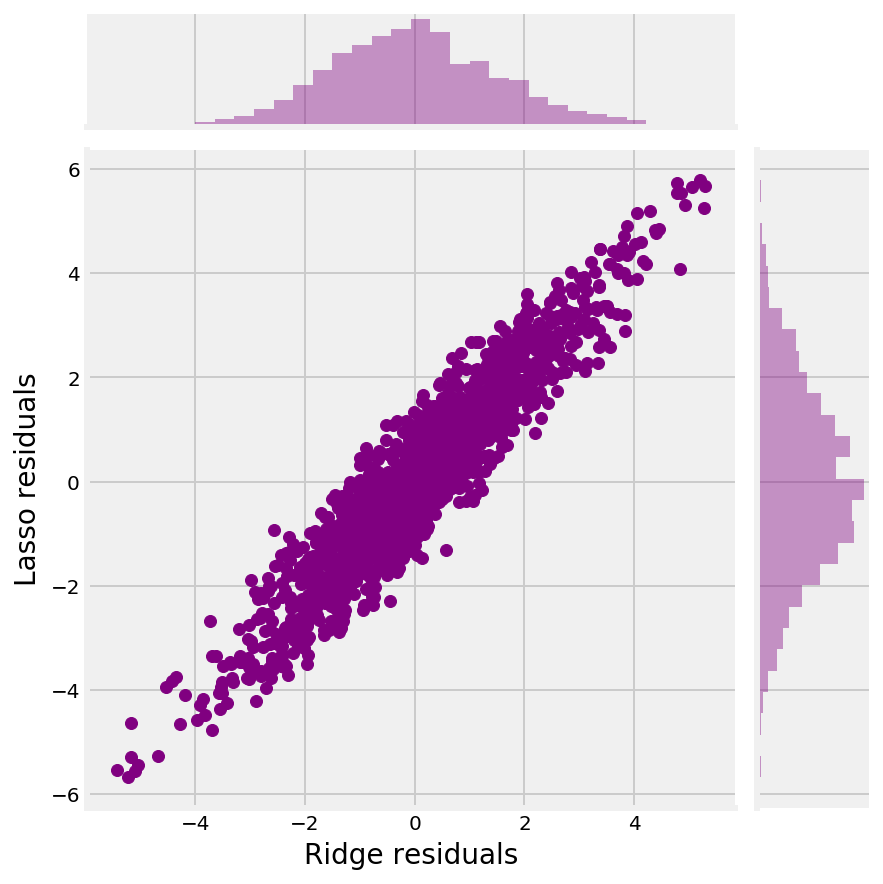

In [48]:
jp = sns.jointplot(x=ridge_resid, y=lasso_resid, color="purple")
jp.set_axis_labels("Ridge residuals", "Lasso residuals", fontsize=14)

In [ ]:
# Marginal plots (top and side) are distribution of ridge residuals and lasso residuals which are similar
# Scatterplot shows linear relationship between the residuals of Ridge and Lasso - when one increases so does the other
# The relationship between the two is very strong in similarity which suggests that both work similarly as modelling options